<a href="https://colab.research.google.com/github/burakayy7/fluBifurcation_deep_learning/blob/main/dlews_flu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install Dependencies
!pip install ewstools==2.1.2
!git clone https://github.com/AmitKChakraborty/EWSofInfectiousDiseases.git
!pip install tensorflow==2.14

fatal: destination path 'EWSofInfectiousDiseases' already exists and is not an empty directory.


# requirements

In [69]:
import pandas as pd
from datetime import datetime


import numpy as np
np.random.seed(0) # Set seed for reproducibility

import matplotlib.pyplot as plt
import os
import os.path
from os import path

import ewstools
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import gc
import numpy as np
import pandas as pd
import random
import sys
import itertools
import tensorflow as tf
from tensorflow.keras.models import load_model
from datetime import datetime


# random.seed(datetime.now())
random.seed(datetime.now().timestamp())
# Tensorflow imports
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # comment out to see TensorFlow warnings
from tensorflow.keras.models import load_model

# Get Data | Format

In [54]:
# create the folder

remove_data = True

state_data_path = '/content/state_data'
predictions_path = '/content/predictions'
ensemble_predictions_path = '/content/predictions/ensemble'

if path.exists(state_data_path) == False:
  os.mkdir(state_data_path)
elif remove_data:
  !rm -rf state_data_path/*

if path.exists(predictions_path) == False:
  os.mkdir(predictions_path)
if not os.path.exists(predictions_path):
    os.makedirs(predictions_path)
if not os.path.exists(ensemble_predictions_path):
    os.makedirs(ensemble_predictions_path)


In [55]:
!rm -rf state_data_path/*

In [56]:
ews_data = 0
ts = 0
data = pd.read_csv('https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/main/target-data/target-hospital-admissions.csv')
data = data.reindex(index=data.index[::-1])
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

input_array = {}

states = data['location_name'].unique()

# for state in states:
#   state_data = data.query(f'location_name == "{state}"')
#   print(len(state_data))


def get_time_series(data, start, end):
    if end > len(data):
        end = int(len(data))
    # trans = end*0.8
    if start < 0:
        start = 0
    # print(end-start)
    # print(len(data))
    # print(end)
    ts_sub = subset_reset = data[start:end].reset_index(drop=True)
    # print(ts_sub)
    ts = ewstools.TimeSeries(data=ts_sub, transition=end-start)
    # ts.state.dropna(inplace=True)
    ts.state = ts.state.fillna(0)
    ts.detrend(method='Lowess', span=0.2)

    residuals = ts.state.iloc[:, 0].values if ts.state.ndim > 1 else ts.state.values

    avg_abs_residuals = np.mean(np.abs(residuals))

    normalized_residuals = residuals / avg_abs_residuals


    ts.state = pd.Series(normalized_residuals, index=ts.state.index)

    ts.state = ts.state.rename('residuals')

    return ts.state

from_time = 10
to_time = 80

for state in states:
  state_data = data.query(f'location_name == "{state}"')
  ews_data = state_data[['date', 'weekly_rate']]

  ews_data = ews_data.set_index('date')['weekly_rate']
  ews_data = ews_data.reset_index(drop=True)


  input_array[state] = ews_data.iloc[from_time:to_time]
  # input_array[state].plot()

  ts_out = get_time_series(ews_data, from_time, to_time)
  ts_out.to_csv(f'{state_data_path}/{state}_data.csv', index=True, header=True)

# ts = get_time_series(ews_data, from_time, to_time)
# ts.to_csv('flu_data.csv', index=True, header=True)

# Apply the Model (s)

In [60]:
# for the input data, you first have to detrend using Lowess (0.2) = residual time series, then normalize it by dividing by
# the average of the entire time series
'''
Apply Noise-induced SIR model data trained DL algorithm to test models
Edited from published codes by Bury et al. (2021), Deep learning for early warning signals of tipping points, PNAS.

'''

#python libraries


classifier_length = 100                                   #classifier_length are 100 and 500
type = 'forced'                                            #types are 'forced' and 'null'
test_model = 'SIRenvN'                                    #test_models are 'SIRwhiteN', 'SIRenvN', 'SIRdemN', 'SEIR', 'COVID'
# NoOFSim = 10                                                #Number of simulation for each type; 7 for COVID, 10 for others
NoOFSim = 1

if not os.path.exists('/content/EWSofInfectiousDiseases/Trained_DL_models_and_testing/data/ml_pred_SIR_CL{}'.format(classifier_length)):
    os.makedirs('../data/ml_pred_SIR_CL{}'.format(classifier_length))




def run_infrence(data_path, output_path):
  for state_data in os.listdir(data_path):
    for simulation in np.arange(1, NoOFSim+1):

      # Filepath to residual time series to make predictions on
      # filepath = '../data/resids/resids_{}_{}{}.csv'.format(test_model, type, simulation)

      filepath = f"{data_path}/{state_data}"

      # Filepath to export ensemble DL predictions to
      # filepath_out = '../data/ml_pred_SIR_CL{}/ensemble_trend_probs_{}{}_{}_len{}.csv'.format(classifier_length, test_model, type, simulation, classifier_length)

      filepath_out = output_path

      # Type of classifier to use (500 or 100)
      ts_len = classifier_length

      '''
      The following two parameters control how many sample points along the
      timeseries are used, and the length between them.  For instance, for an input
      time series equal to or less then length 500, mult_factor=10 and
      pad_samples=50 means that it will do the unveiling in steps of 10 datapoints,
      at 50 evenly spaced points across the entire time series (50 x 10 = 500).
      Needs to be adjusted according to whether you are using the trained 500 length
      or 100 length classifier.
      '''

      # Steps of datapoints in between each DL prediction
      mult_factor = 5

      # Total number of DL predictions to make
      pad_samples = int(classifier_length/mult_factor)

      df = pd.read_csv(filepath).dropna()
      # Length of inupt time series
      df_len = len(df)

      if df_len > ts_len:
          #df of last classifier_length=500 points
          df_last = df[-classifier_length:]
          resids = df_last['residuals'].values.reshape(1,-1,1)
          input_series = resids
          seq_len = len(df_last)
      else:
          resids = df['residuals'].values.reshape(1,-1,1)
          # Length of inupt time series
          seq_len = len(df)
          input_series = resids

      def get_dl_predictions(resids, model_type, kk):

          '''
          Generate DL prediction time series on resids
          from DL classifier with type 'model_type' and index kk.
          '''

          # Setup file to store DL predictions
          predictions_file_name = '{}/y_pred_{}_{}.csv'.format(predictions_path,kk,model_type)
          f1 = open(predictions_file_name,'w')

          # Load in specific DL classifier
          model_name = '/content/EWSofInfectiousDiseases/Trained_DL_models_and_testing/trained_DL_models_and_DL_apply/trained_models_Noise_Induced_SIR_CL{}/best_model_{}_{}_length{}.pkl'.format(classifier_length, kk,model_type, ts_len)
          model = load_model(model_name)

          # Loop through each possible length of padding
          # Start with revelaing the DL algorith only the earliest points
          for pad_count in range(pad_samples-1, -1, -1):

              temp_ts = np.zeros((1,ts_len,1))

              ts_gap = ts_len-seq_len
              pad_length = mult_factor*pad_count

              if pad_length + ts_gap > ts_len:
                  zero_range = ts_len
              else:
                  zero_range = pad_length + ts_gap

              if zero_range == ts_len:
                  # Set all ML predictions to zero
                  y_pred = np.zeros(2).reshape(1,2)
              else:
                  for j in range(0, zero_range):
                      temp_ts[0,j] = 0
                  for j in range(zero_range, ts_len):
                      temp_ts[0,j] = resids[0,j-zero_range]

                  # normalizing inputs: take averages, since the models were also trained on averaged data.
                  values_avg = 0.0
                  count_avg = 0
                  for j in range (0,ts_len):
                      if temp_ts[0,j] != 0:
                          values_avg = values_avg + abs(temp_ts[0,j])
                          count_avg = count_avg + 1
                  if count_avg != 0:
                      values_avg = values_avg/count_avg
                  for j in range (0,ts_len):
                      if temp_ts[0,j] != 0:
                          temp_ts[0,j] = temp_ts[0,j]/values_avg

                  # Compute DL prediction
                  y_pred = model.predict(temp_ts)



              # Write predictions to file
              np.savetxt(f1, y_pred, delimiter=',')
              print('Predictions computed for padding={}'.format(pad_count*mult_factor))

          # Delete model and do garbage collection to free up RAM
          tf.keras.backend.clear_session()
          if zero_range != ts_len:
              del model
          gc.collect()
          f1.close()

          return



      # Compute DL predictions from all 20 trained models

      # for model_type in [1,2]:
      #     for kk in np.arange(1,2):
      #         print('Compute DL predictions for model_type={}, kk={}'.format(
      #             model_type,kk))

      #         get_dl_predictions(resids, model_type, kk)
      for model_type in [1]:
          for kk in np.arange(1,2):
              print('Compute DL predictions for model_type={}, kk={}'.format(
                  model_type,kk))

              get_dl_predictions(resids, model_type, kk)




      # Compute average prediction among all 20 DL classifiers
      # list_df_preds = []
      # for model_type in [1,2]:
      #     for kk in np.arange(1,2):
      #         filename = 'predictions/y_pred_{}_{}.csv'.format(kk,model_type)
      #         df_preds = pd.read_csv(filename,header=None)
      #         df_preds['time_index'] = df_preds.index
      #         df_preds['model_type'] = model_type
      #         df_preds['kk'] = kk
      #         list_df_preds.append(df_preds)
      list_df_preds = []
      for model_type in [1]:
          for kk in np.arange(1,2):
              filename = 'predictions/y_pred_{}_{}.csv'.format(kk,model_type)
              df_preds = pd.read_csv(filename,header=None)
              df_preds['time_index'] = df_preds.index
              df_preds['model_type'] = model_type
              df_preds['kk'] = kk
              list_df_preds.append(df_preds)


      # Concatenate
      df_preds_all = pd.concat(list_df_preds).reset_index(drop=True)

      # Compute mean over all predictions
      df_preds_mean = df_preds_all.groupby('time_index').mean()
      df_preds_mean = df_preds_mean[[0,1]]
      df_preds_mean = df_preds_mean.assign(b=df_preds_mean.iloc[:,[1]].sum(axis=1))

      # Export predictions
      filepath_out_state = f"{output_path}/ensemble_preds_{state_data}"
      df_preds_mean.iloc[:,[0,1,2]].to_csv(filepath_out_state,index=False,header=False)


output_path = ensemble_predictions_path
run_infrence(state_data_path, output_path)


Compute DL predictions for model_type=1, kk=1
Predictions computed for padding=95
Predictions computed for padding=90
Predictions computed for padding=85
Predictions computed for padding=80
Predictions computed for padding=75
Predictions computed for padding=70
1/1 [==============================] - 1s 651ms/step
Predictions computed for padding=65
1/1 [==============================] - 0s 19ms/step
Predictions computed for padding=60
1/1 [==============================] - 0s 19ms/step
Predictions computed for padding=55
1/1 [==============================] - 0s 19ms/step
Predictions computed for padding=50
1/1 [==============================] - 0s 20ms/step
Predictions computed for padding=45
1/1 [==============================] - 0s 24ms/step
Predictions computed for padding=40
1/1 [==============================] - 0s 19ms/step
Predictions computed for padding=35
1/1 [==============================] - 0s 20ms/step
Predictions computed for padding=30
1/1 [============================

# Plot predictions

prediction index meanings

**1 - Fold bifurcation**


**2 - Hopf bifurcation**


**3 - transcritical bifurcation**

Virginia


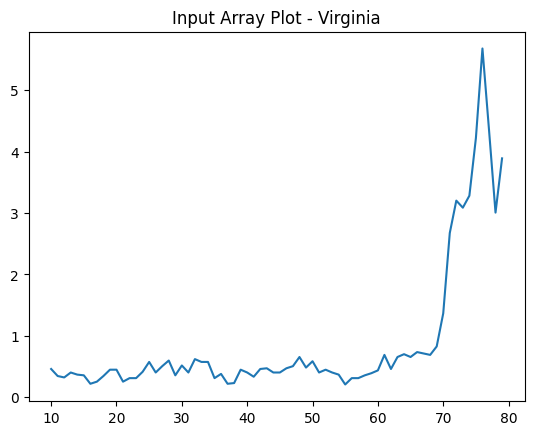

<Figure size 640x480 with 0 Axes>

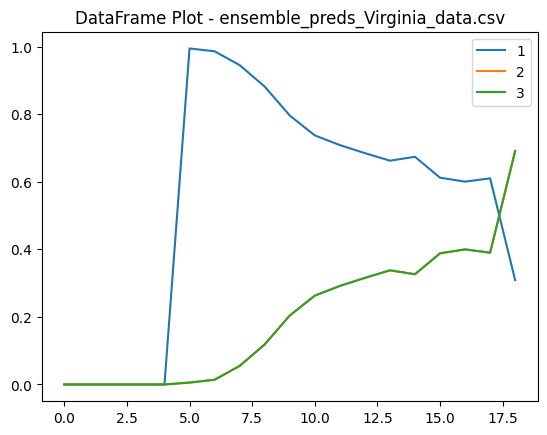

Wisconsin


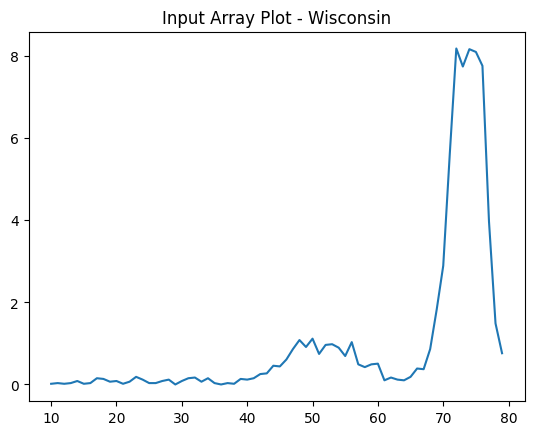

<Figure size 640x480 with 0 Axes>

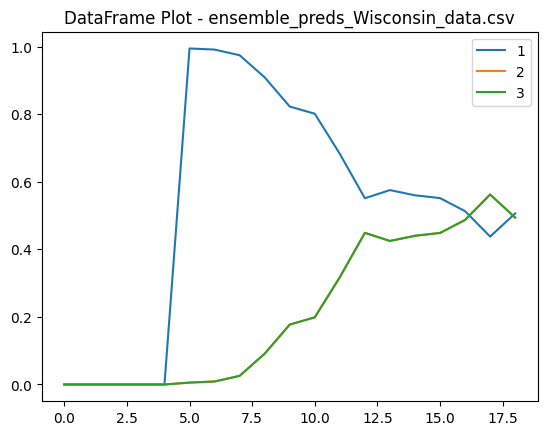

New Jersey


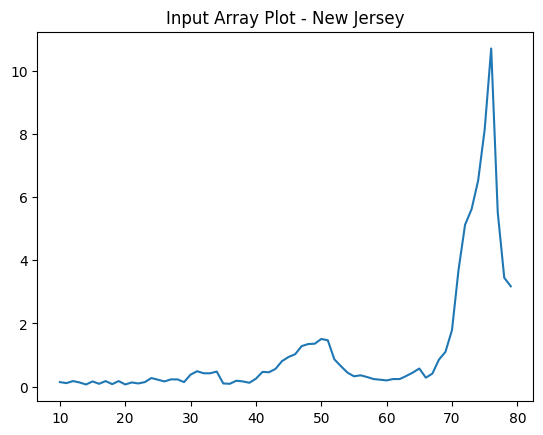

<Figure size 640x480 with 0 Axes>

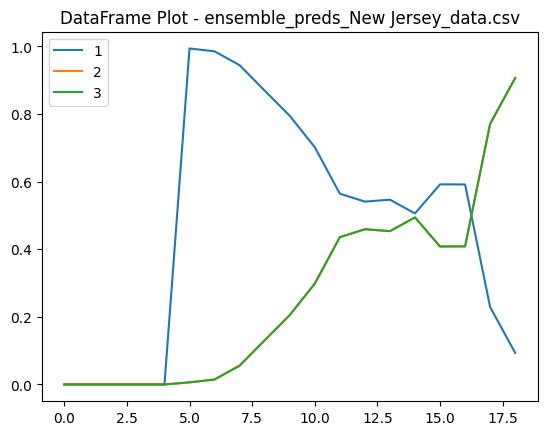

Nevada


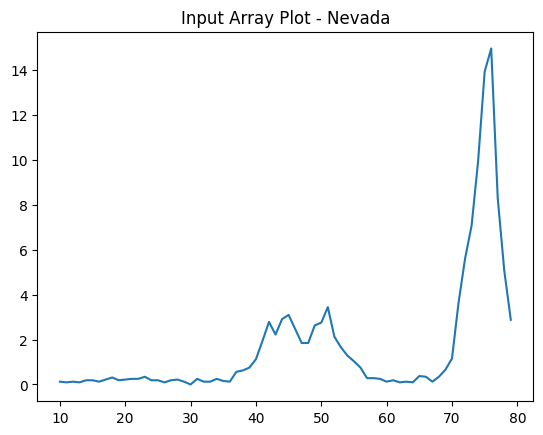

<Figure size 640x480 with 0 Axes>

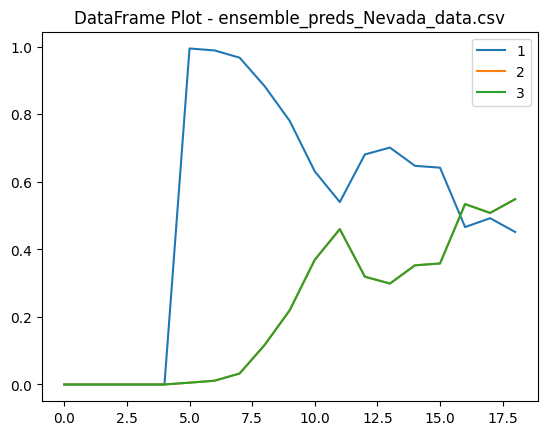

Arizona


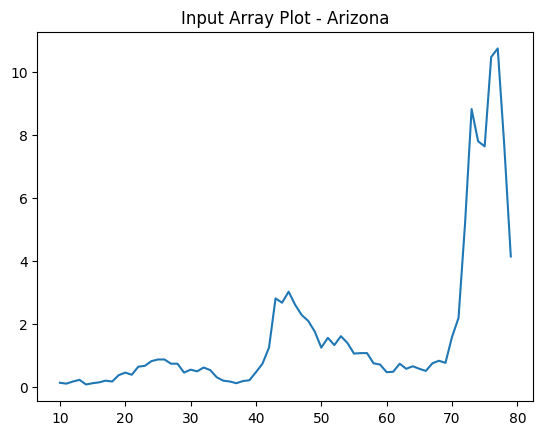

<Figure size 640x480 with 0 Axes>

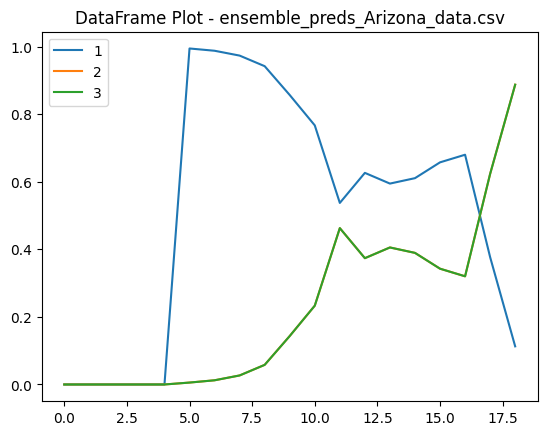

Delaware


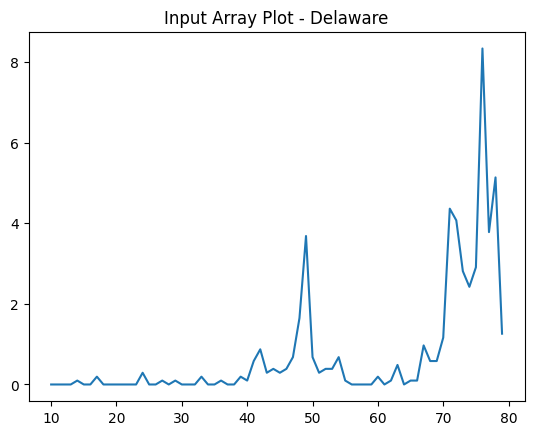

<Figure size 640x480 with 0 Axes>

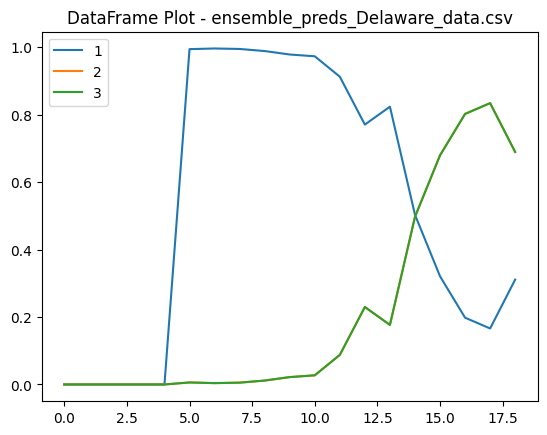

Texas


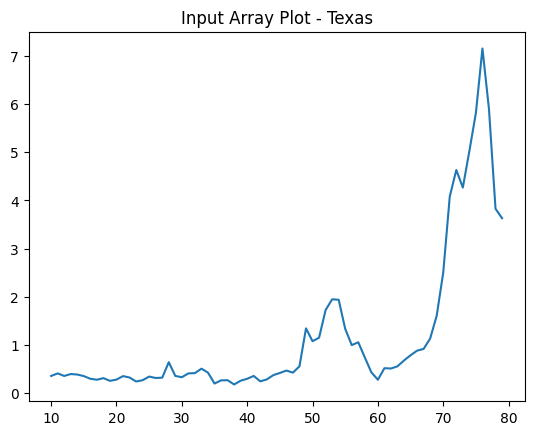

<Figure size 640x480 with 0 Axes>

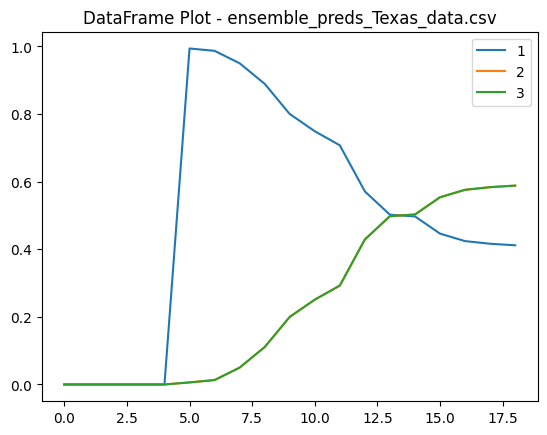

Alabama


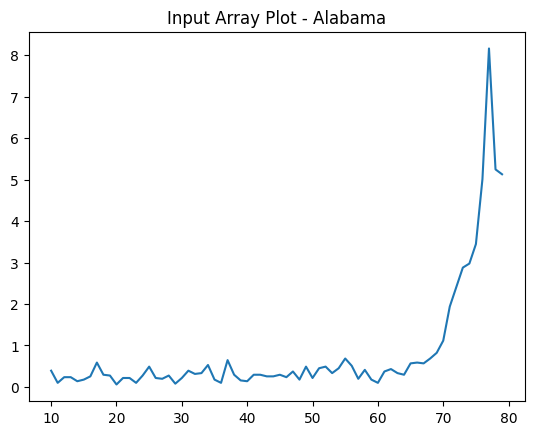

<Figure size 640x480 with 0 Axes>

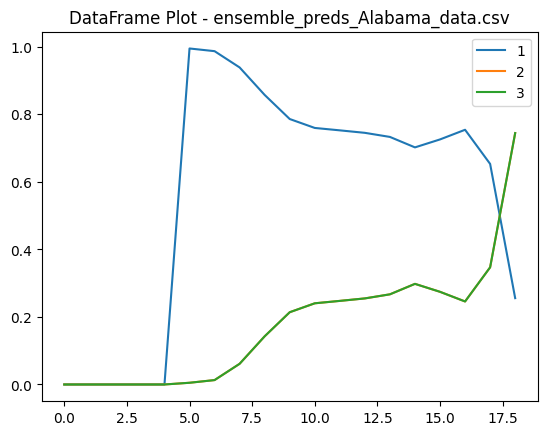

Utah


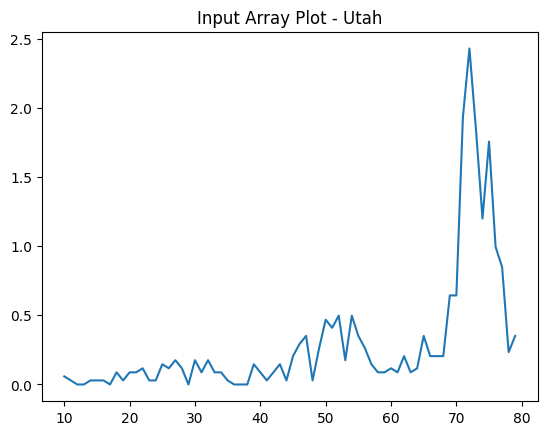

<Figure size 640x480 with 0 Axes>

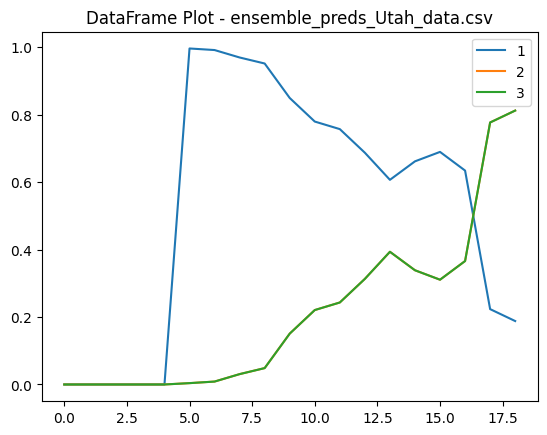

Massachusetts


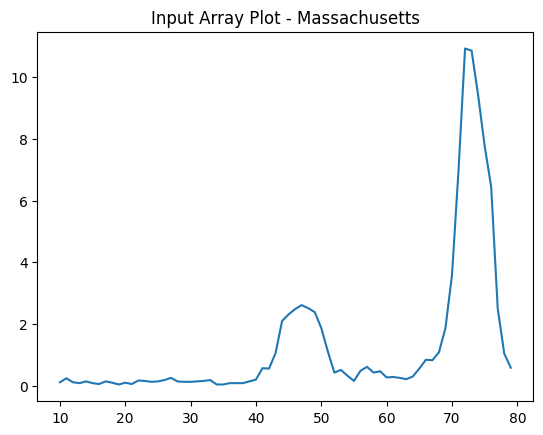

<Figure size 640x480 with 0 Axes>

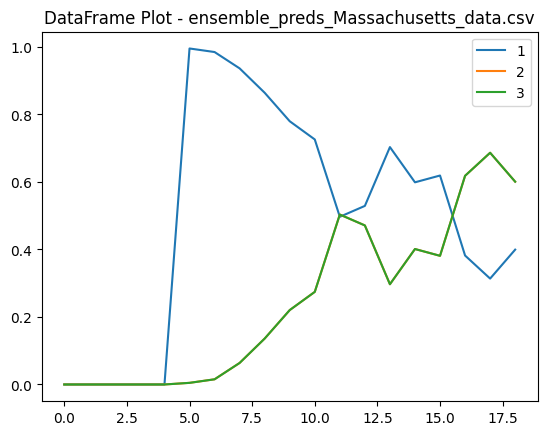

South Carolina


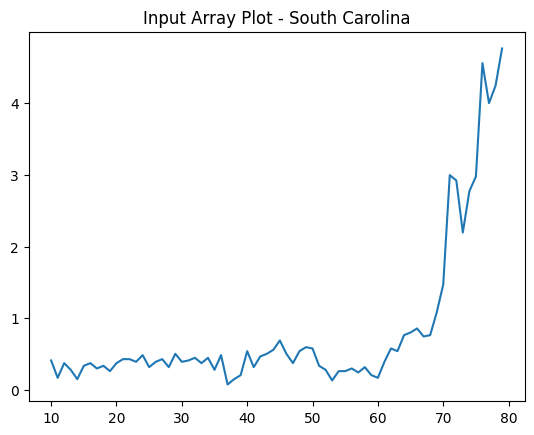

<Figure size 640x480 with 0 Axes>

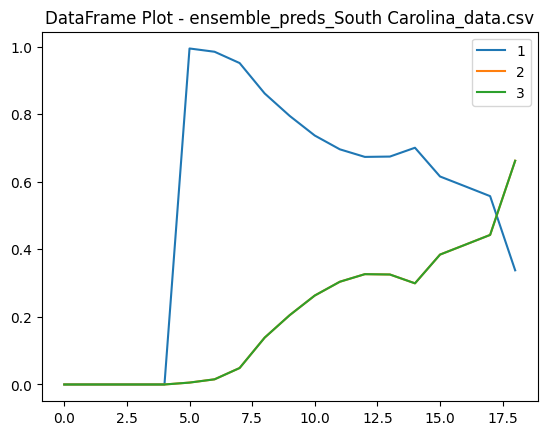

Indiana


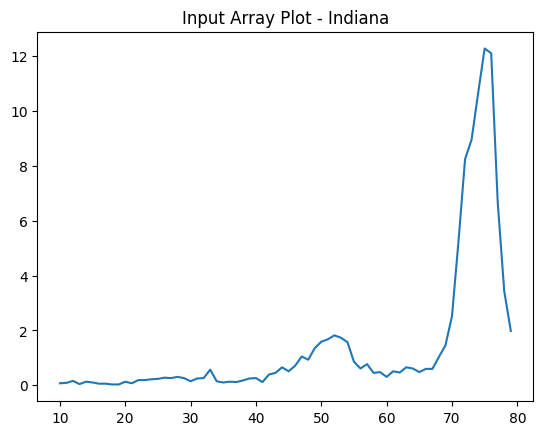

<Figure size 640x480 with 0 Axes>

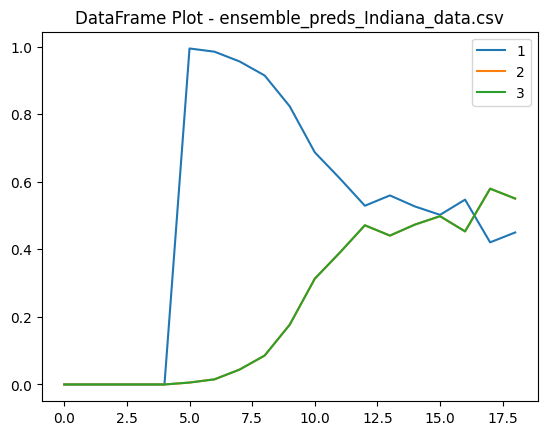

Florida


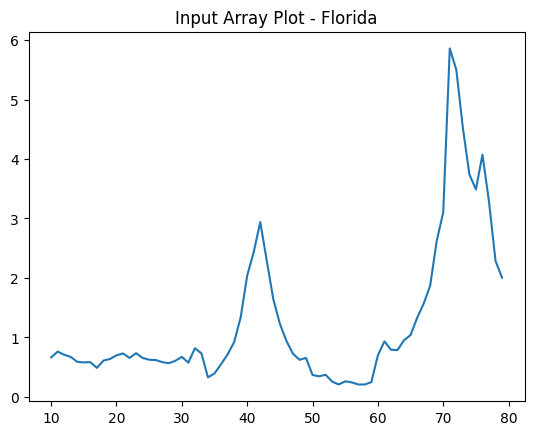

<Figure size 640x480 with 0 Axes>

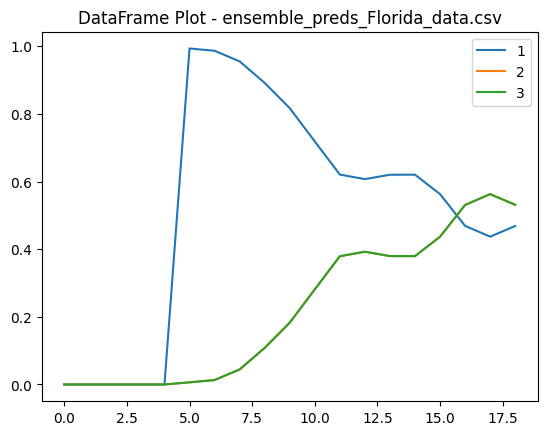

Iowa


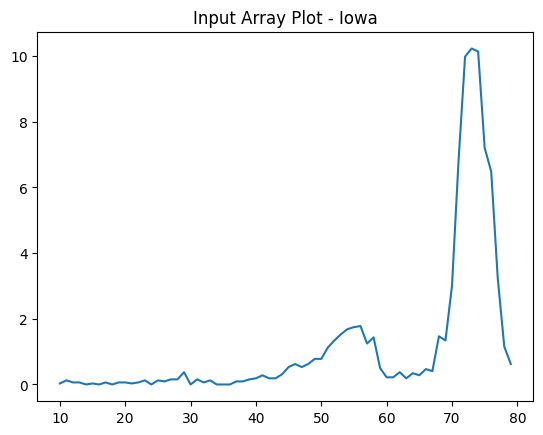

<Figure size 640x480 with 0 Axes>

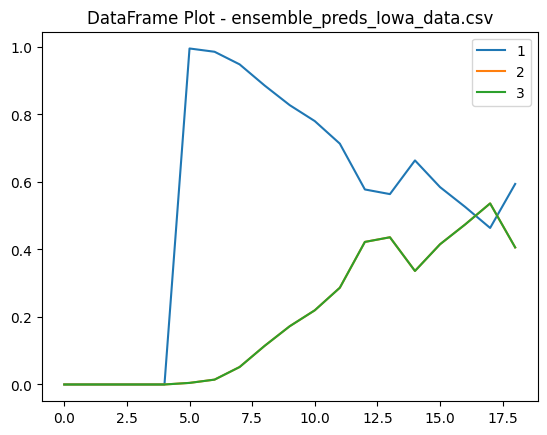

Oregon


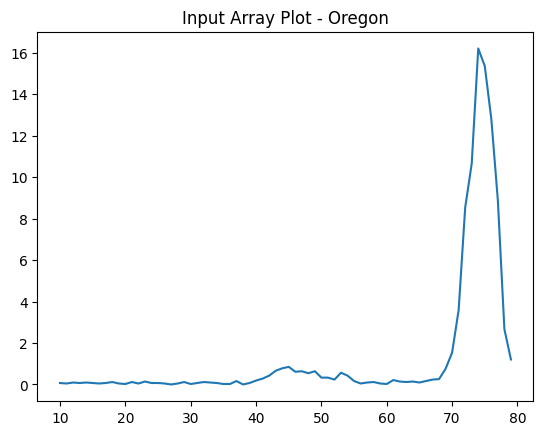

<Figure size 640x480 with 0 Axes>

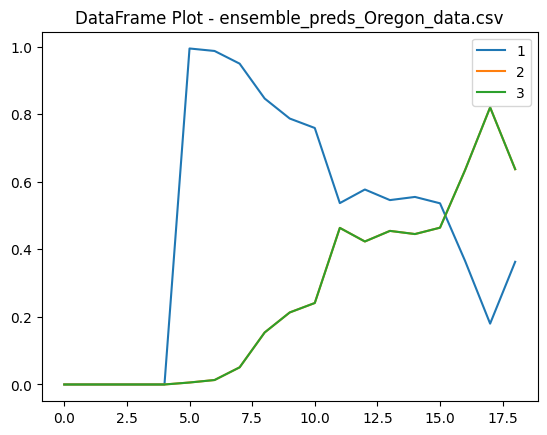

Washington


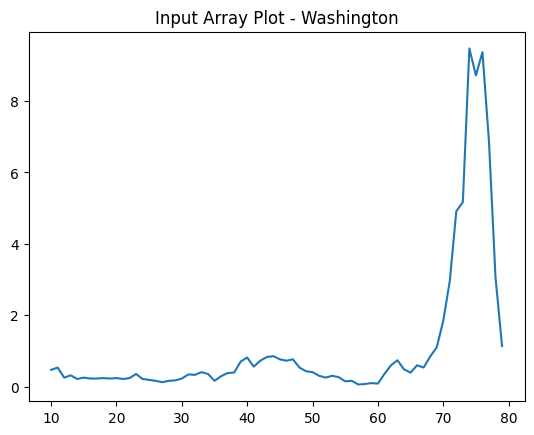

<Figure size 640x480 with 0 Axes>

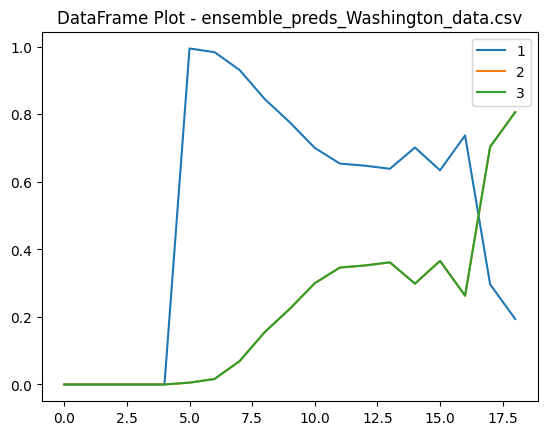

North Dakota


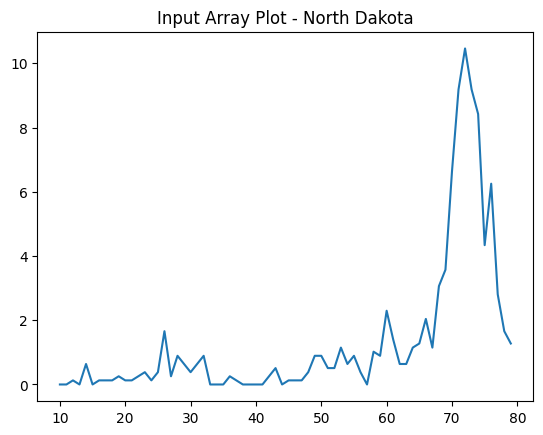

<Figure size 640x480 with 0 Axes>

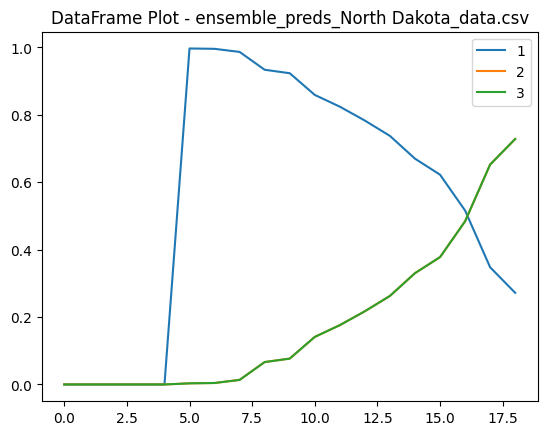

West Virginia


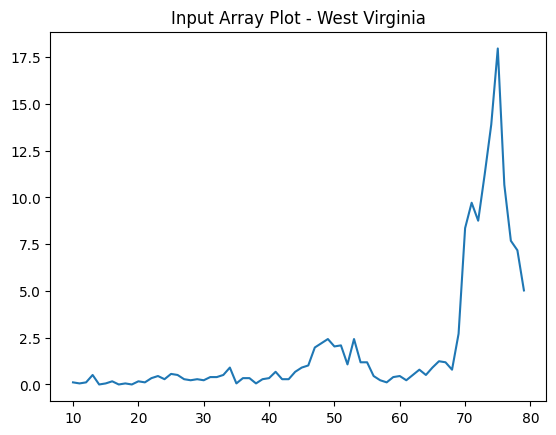

<Figure size 640x480 with 0 Axes>

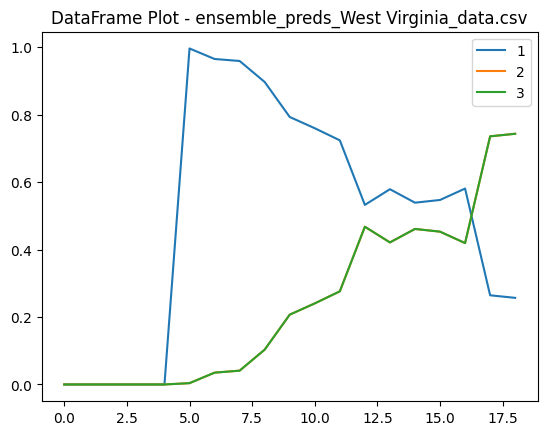

Louisiana


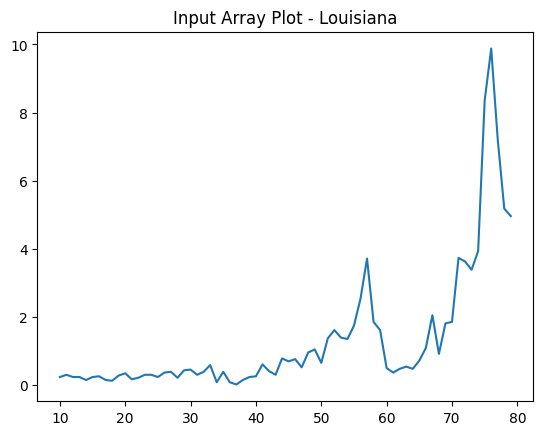

<Figure size 640x480 with 0 Axes>

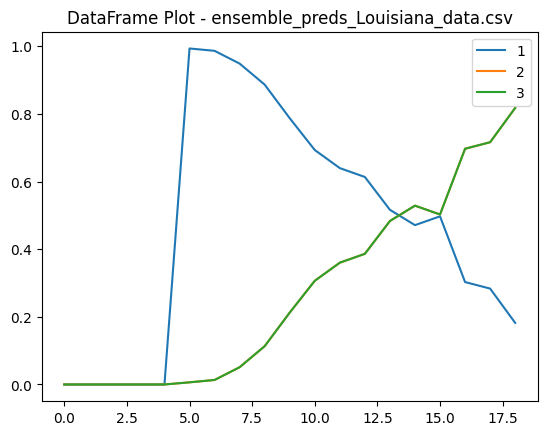

Oklahoma


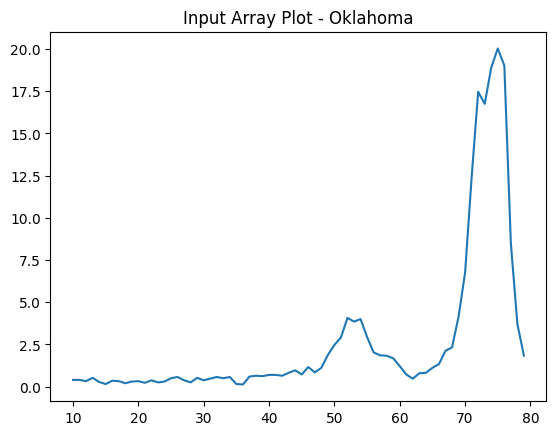

<Figure size 640x480 with 0 Axes>

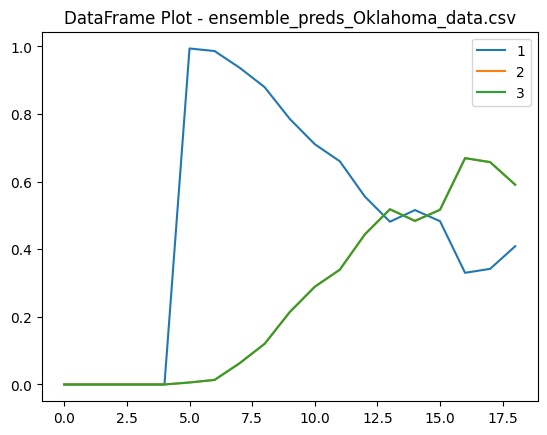

New Mexico


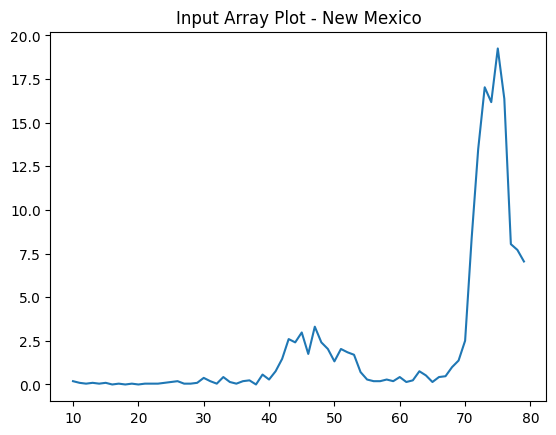

<Figure size 640x480 with 0 Axes>

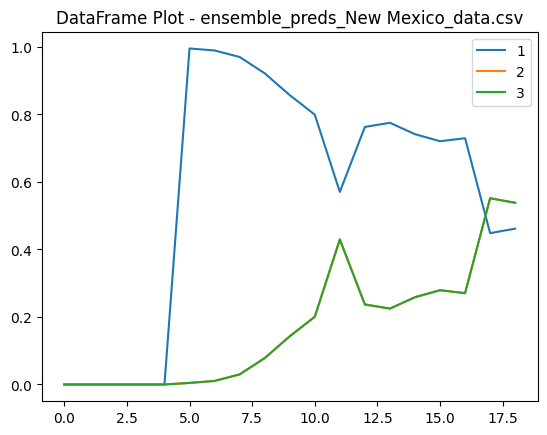

North Carolina


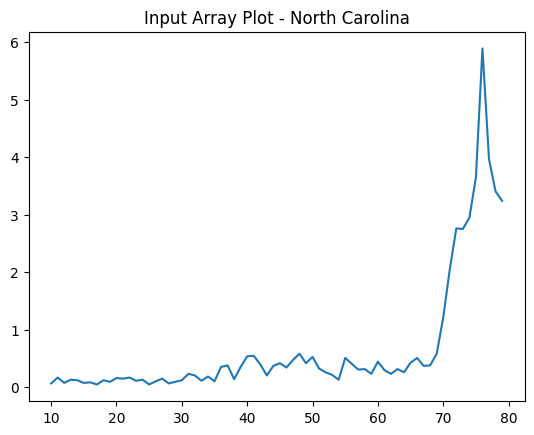

<Figure size 640x480 with 0 Axes>

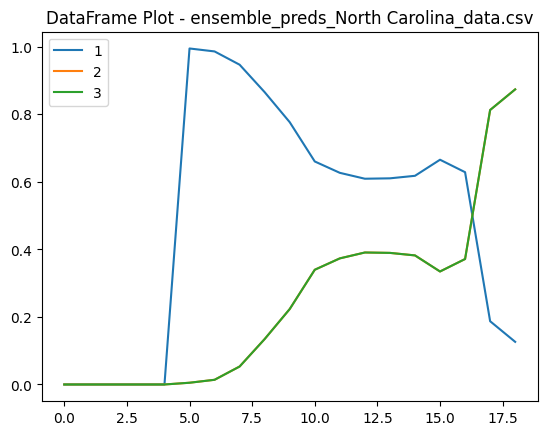

California


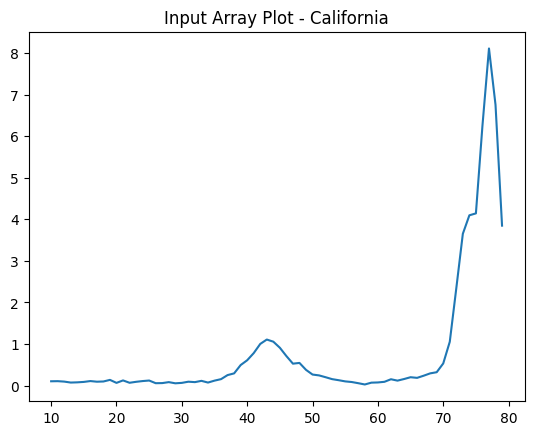

<Figure size 640x480 with 0 Axes>

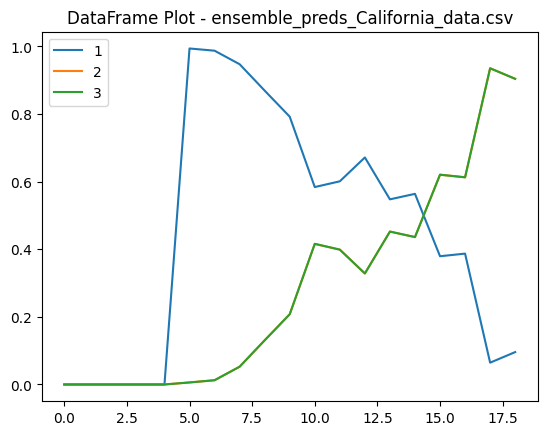

Alaska


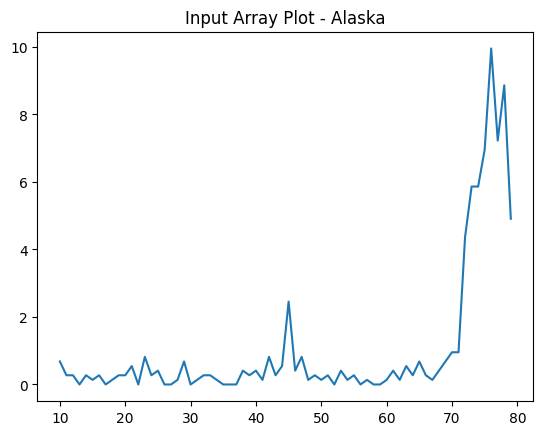

<Figure size 640x480 with 0 Axes>

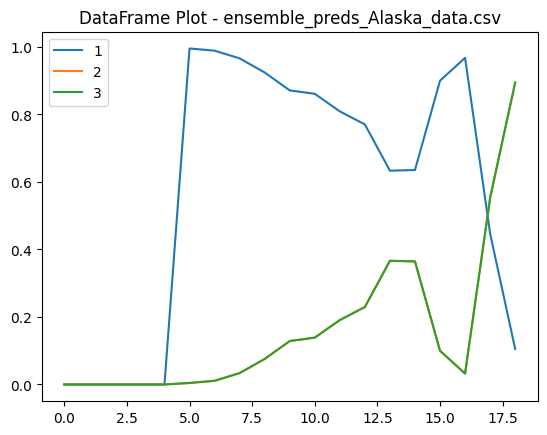

Maryland


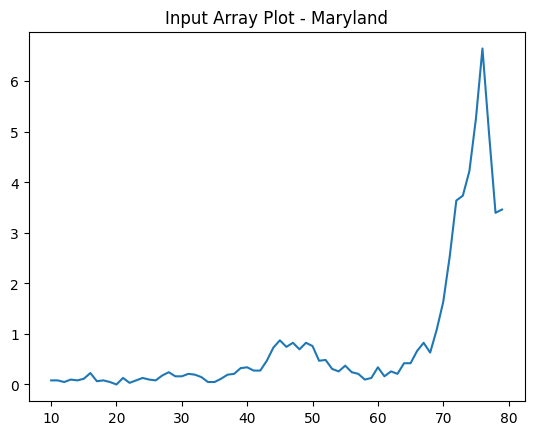

<Figure size 640x480 with 0 Axes>

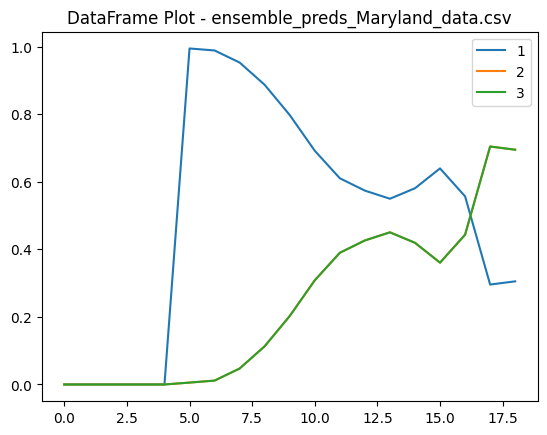

Minnesota


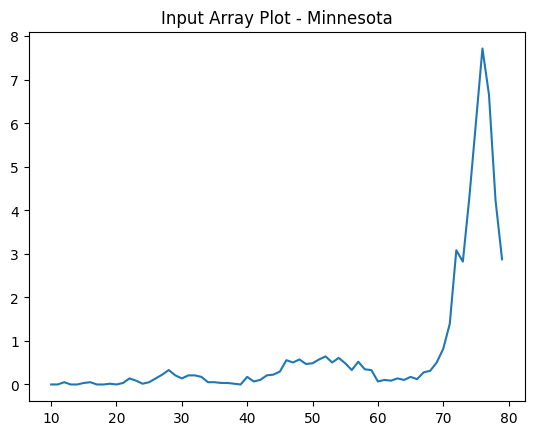

<Figure size 640x480 with 0 Axes>

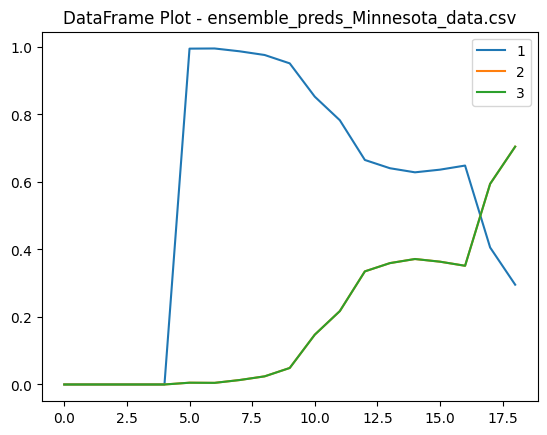

Rhode Island


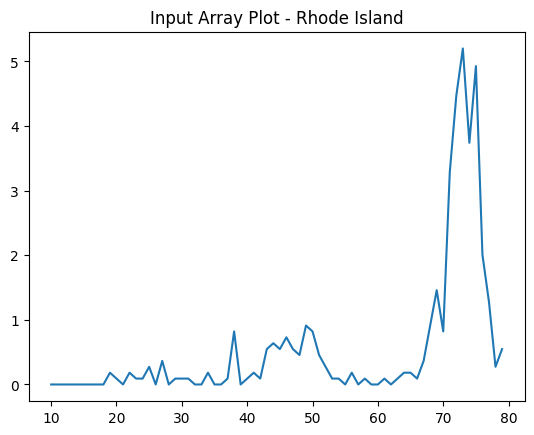

<Figure size 640x480 with 0 Axes>

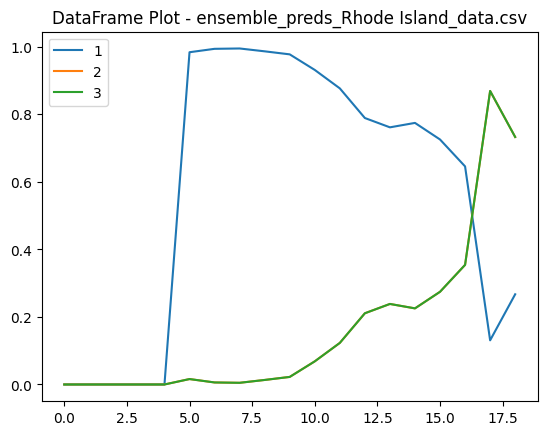

Arkansas


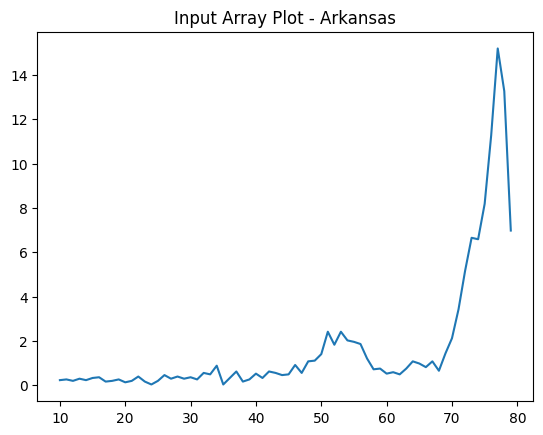

<Figure size 640x480 with 0 Axes>

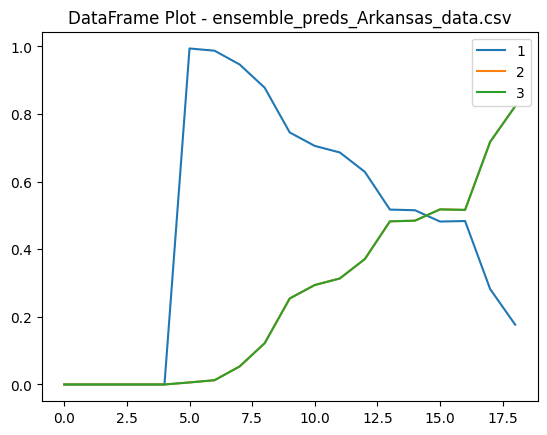

Vermont


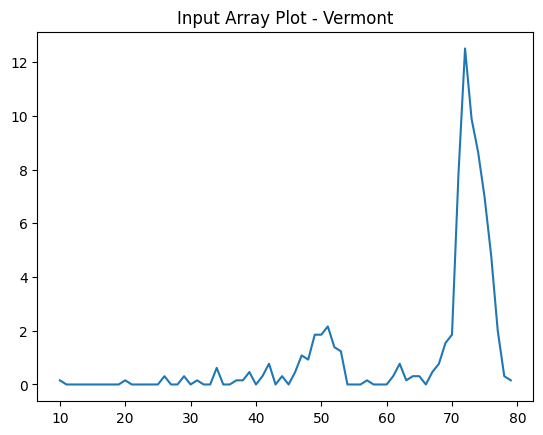

<Figure size 640x480 with 0 Axes>

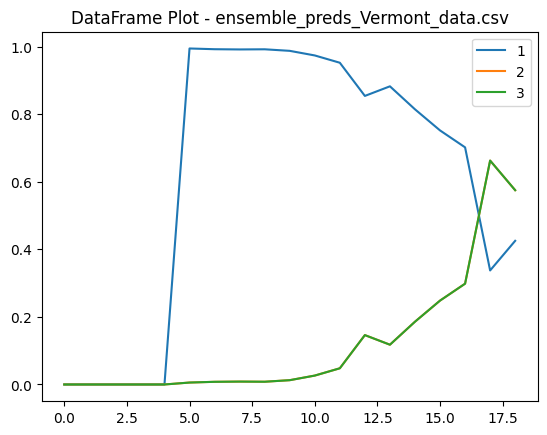

New Hampshire


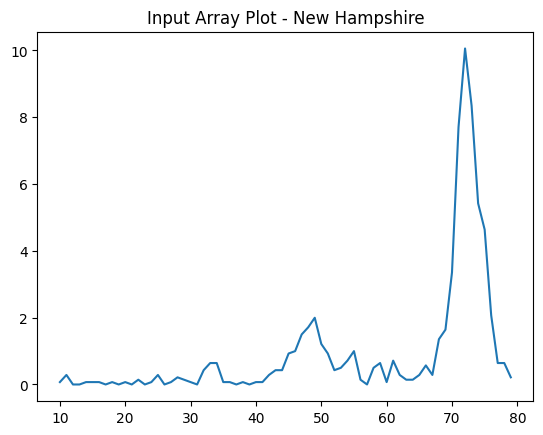

<Figure size 640x480 with 0 Axes>

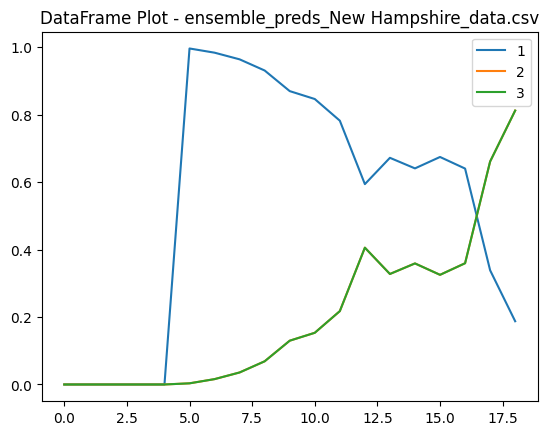

Michigan


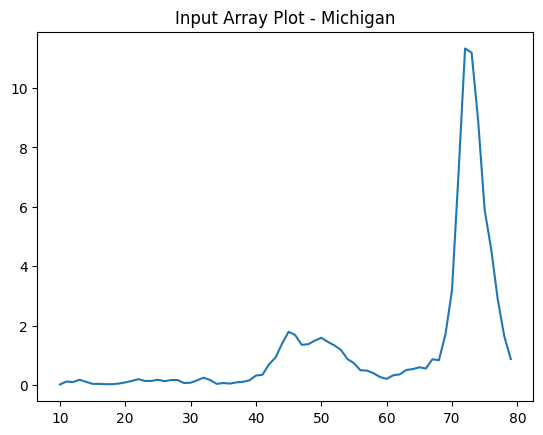

<Figure size 640x480 with 0 Axes>

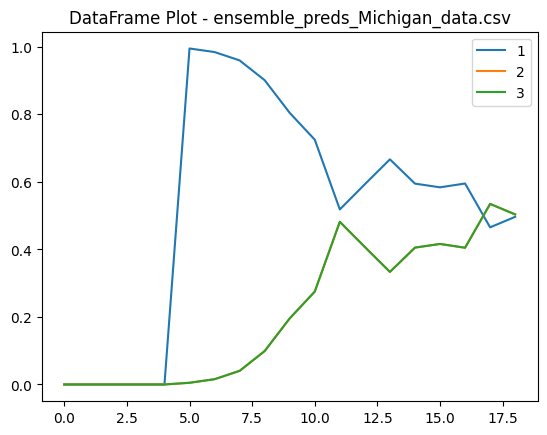

Connecticut


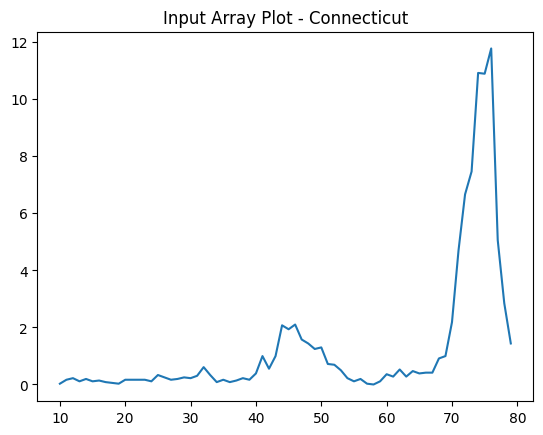

<Figure size 640x480 with 0 Axes>

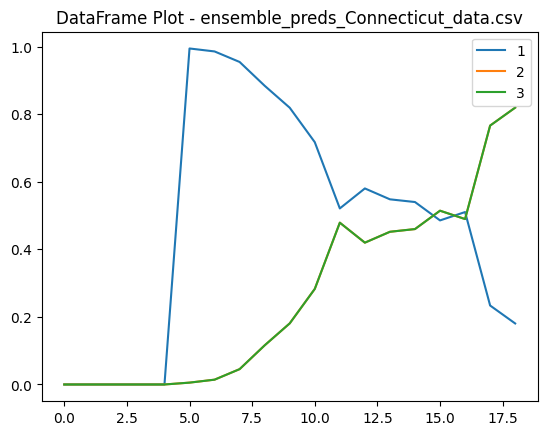

Mississippi


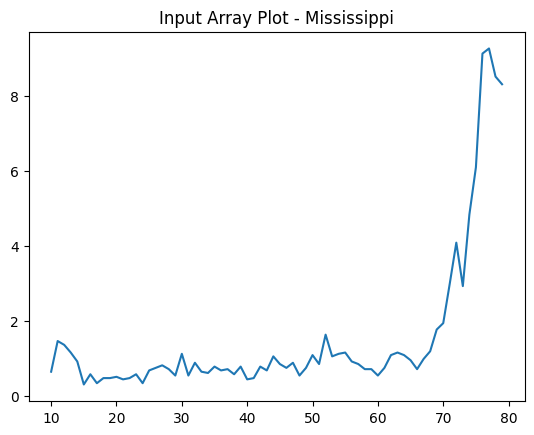

<Figure size 640x480 with 0 Axes>

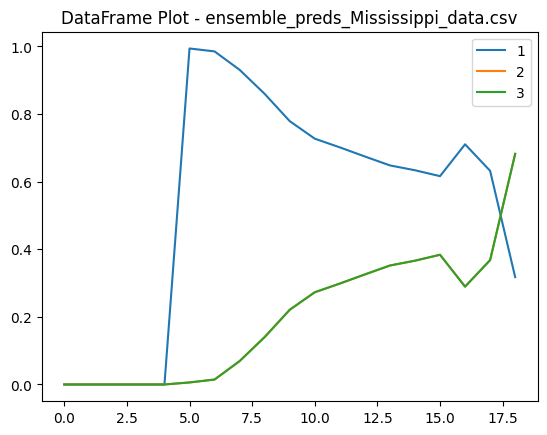

Colorado


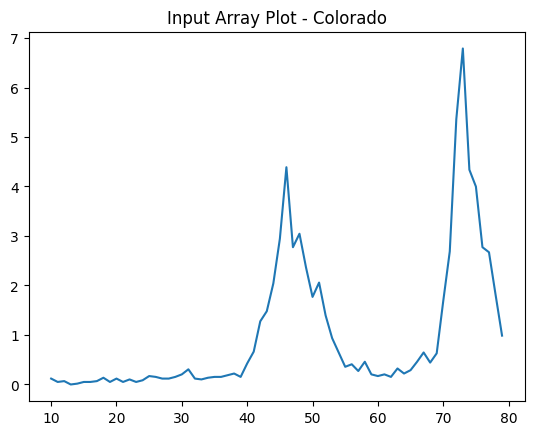

<Figure size 640x480 with 0 Axes>

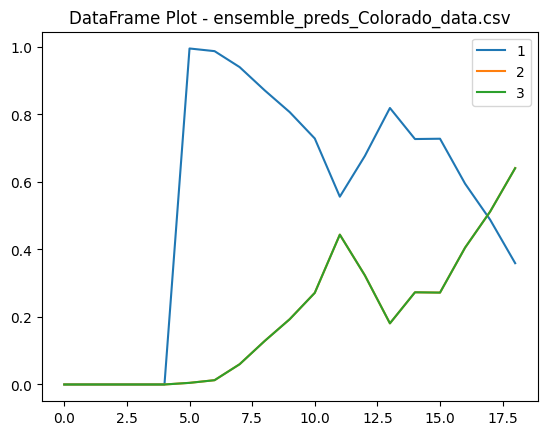

Tennessee


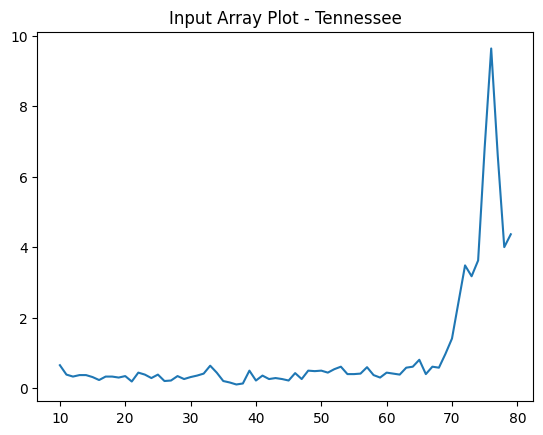

<Figure size 640x480 with 0 Axes>

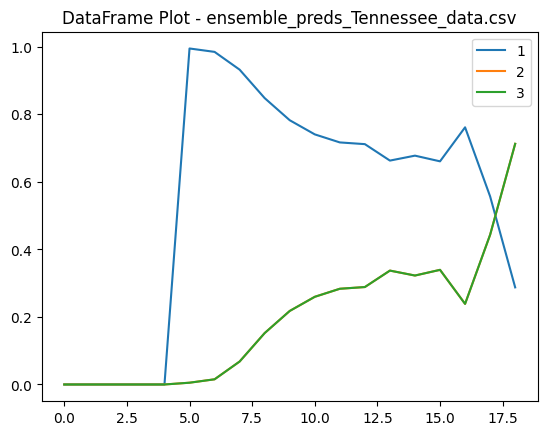

Kentucky


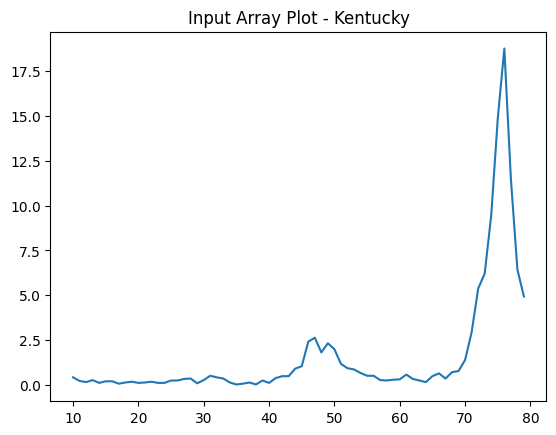

<Figure size 640x480 with 0 Axes>

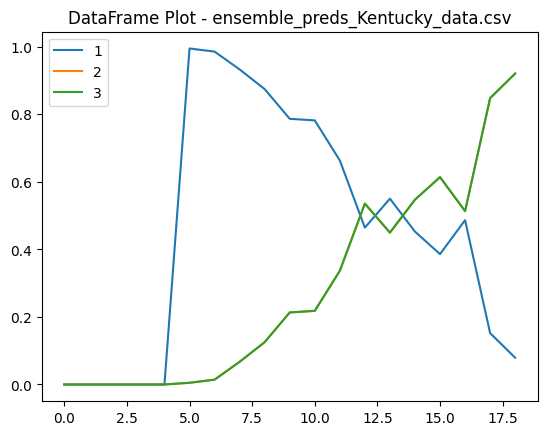

US


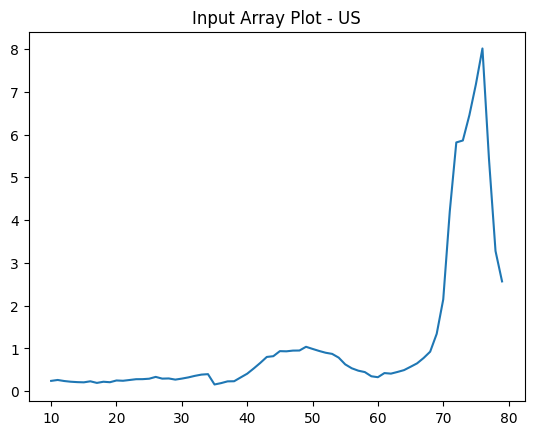

<Figure size 640x480 with 0 Axes>

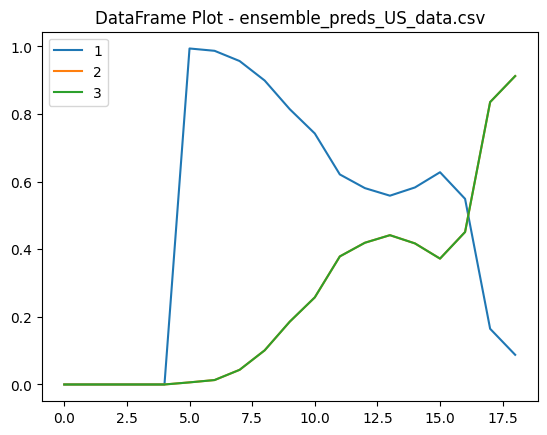

Wyoming


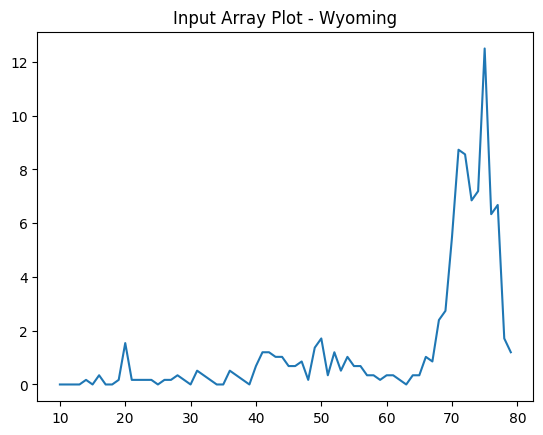

<Figure size 640x480 with 0 Axes>

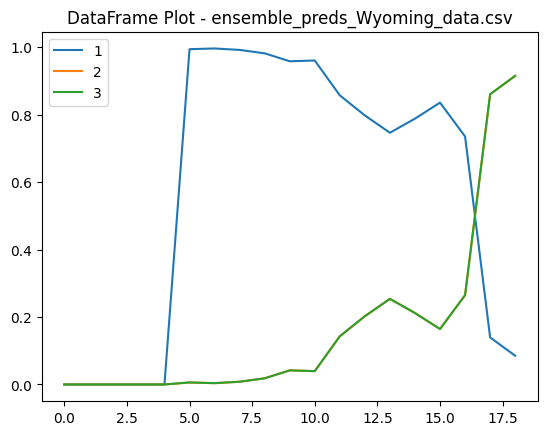

Montana


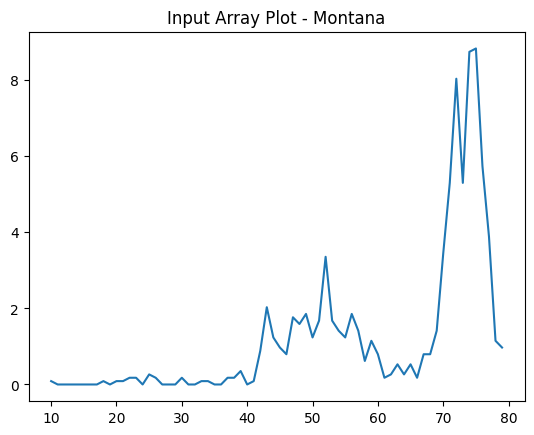

<Figure size 640x480 with 0 Axes>

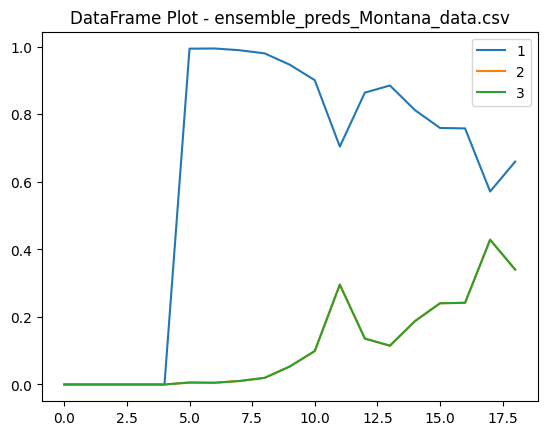

Hawaii


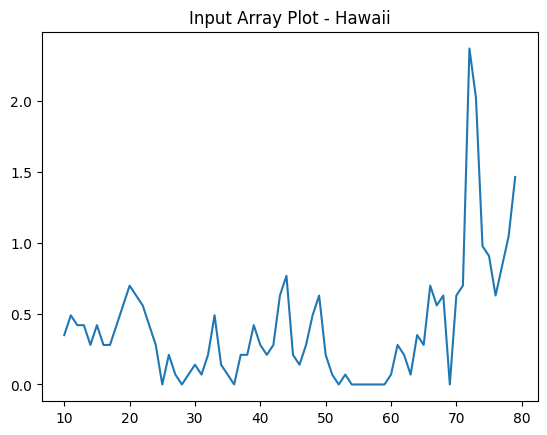

<Figure size 640x480 with 0 Axes>

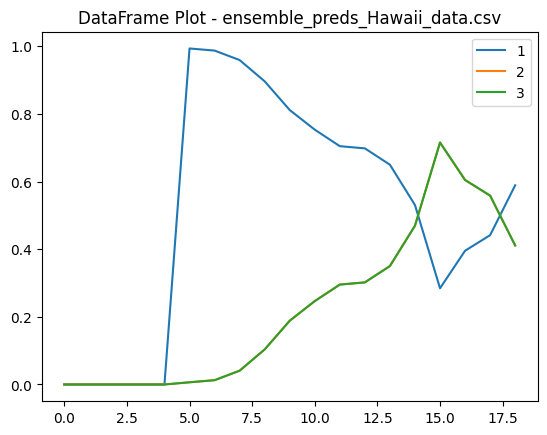

Missouri


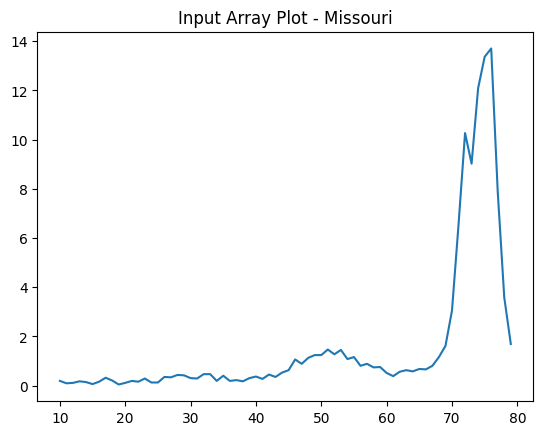

<Figure size 640x480 with 0 Axes>

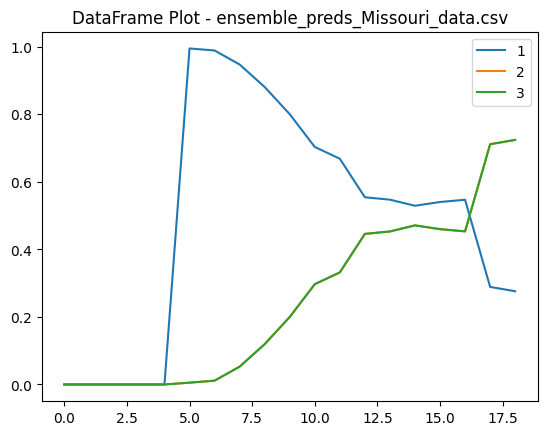

Idaho


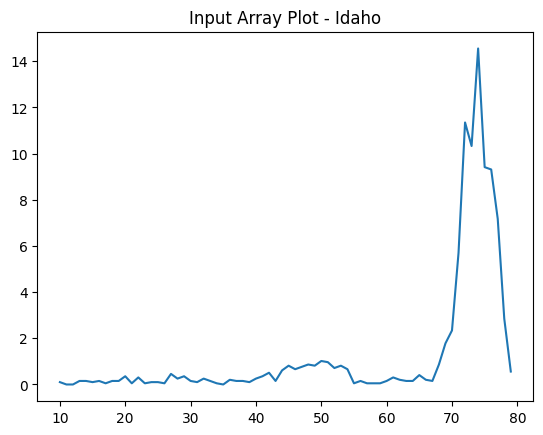

<Figure size 640x480 with 0 Axes>

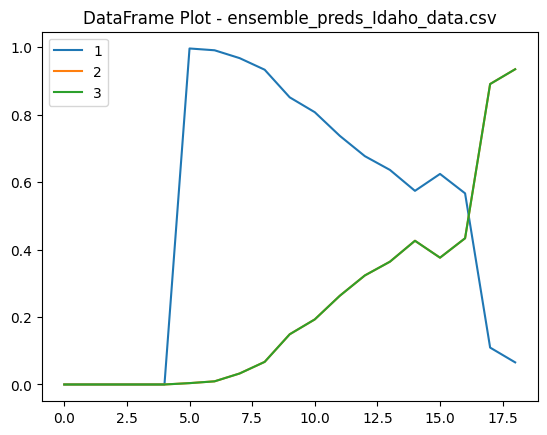

New York


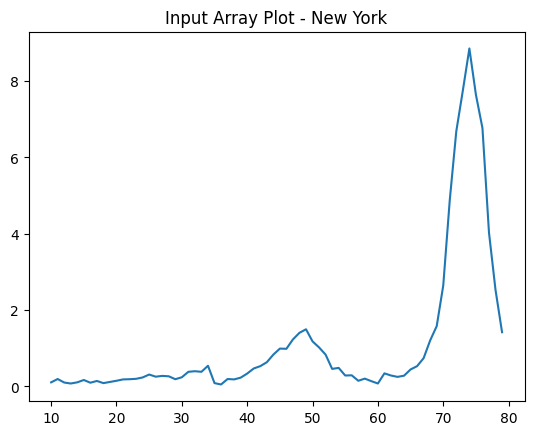

<Figure size 640x480 with 0 Axes>

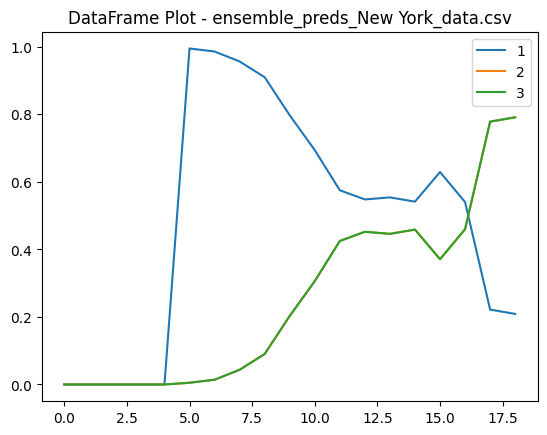

Georgia


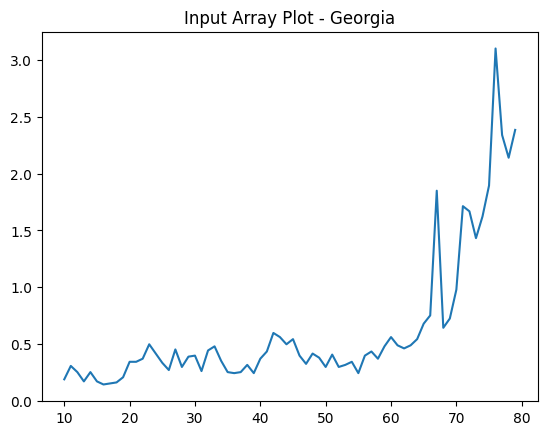

<Figure size 640x480 with 0 Axes>

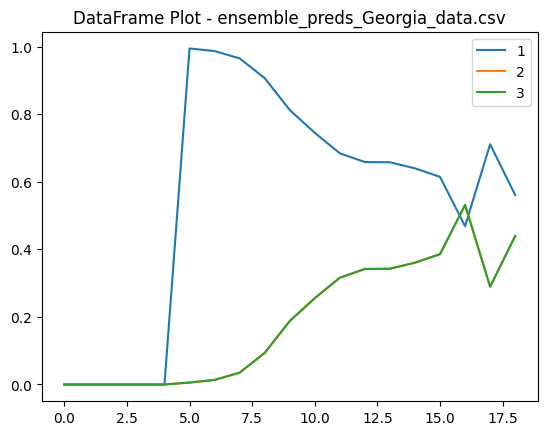

Kansas


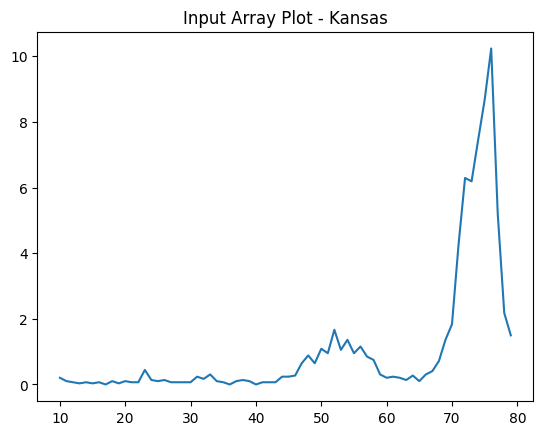

<Figure size 640x480 with 0 Axes>

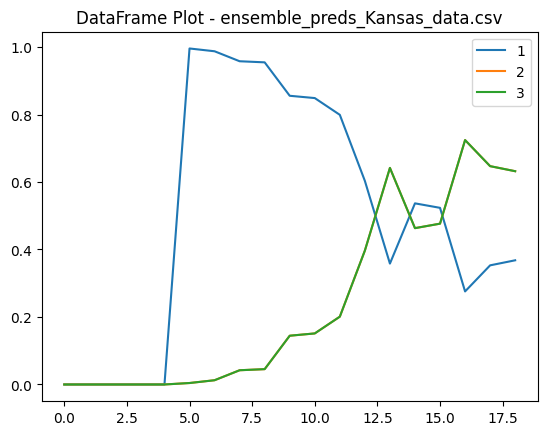

Ohio


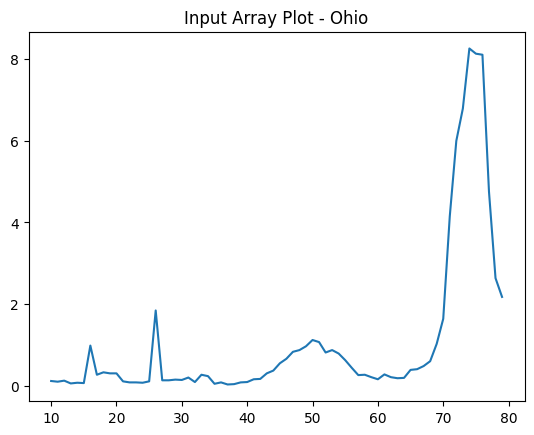

<Figure size 640x480 with 0 Axes>

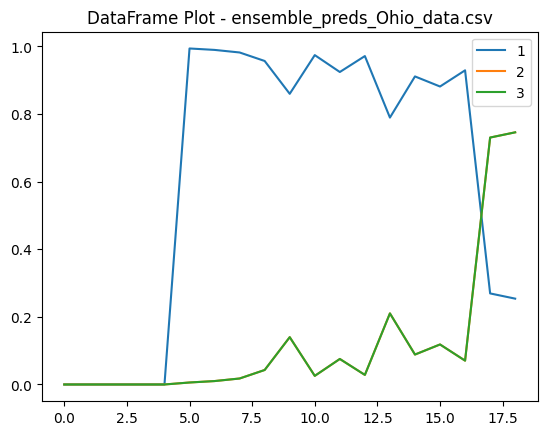

Pennsylvania


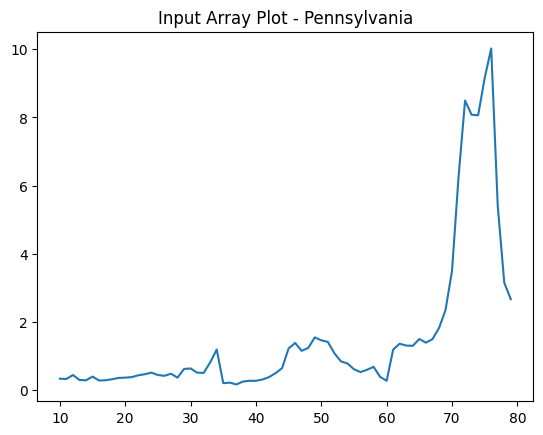

<Figure size 640x480 with 0 Axes>

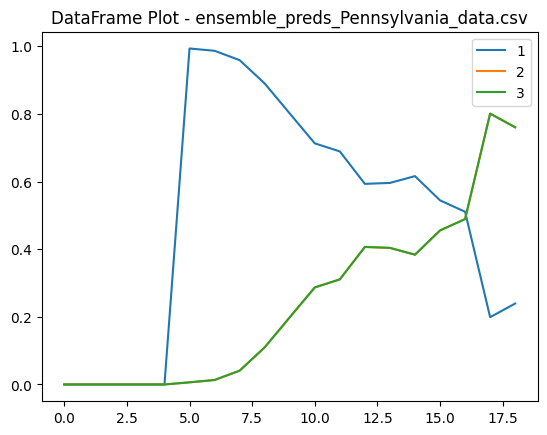

Maine


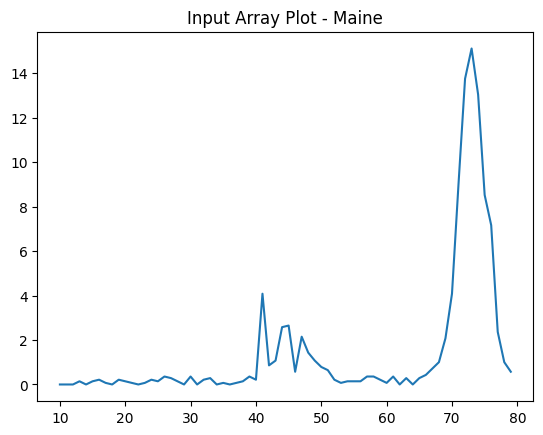

<Figure size 640x480 with 0 Axes>

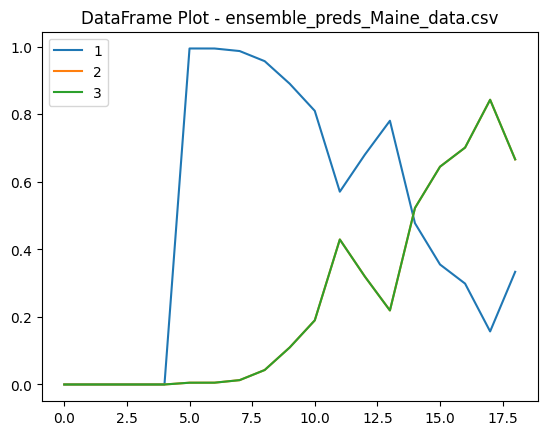

Nebraska


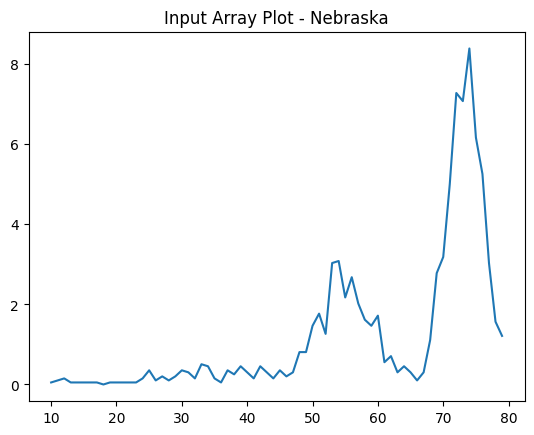

<Figure size 640x480 with 0 Axes>

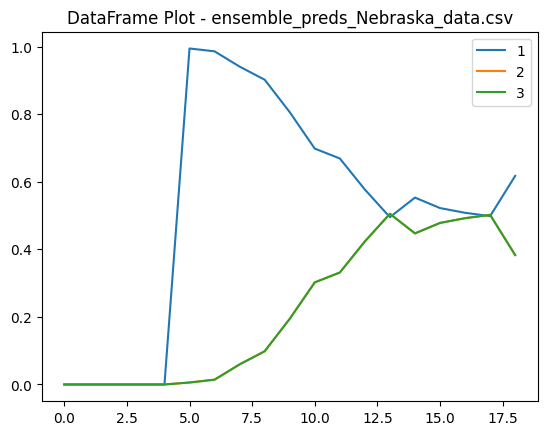

South Dakota


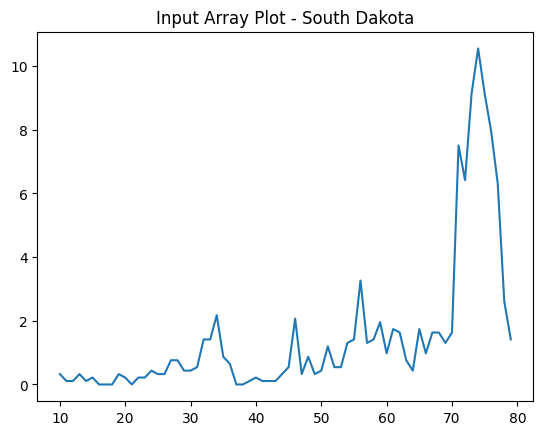

<Figure size 640x480 with 0 Axes>

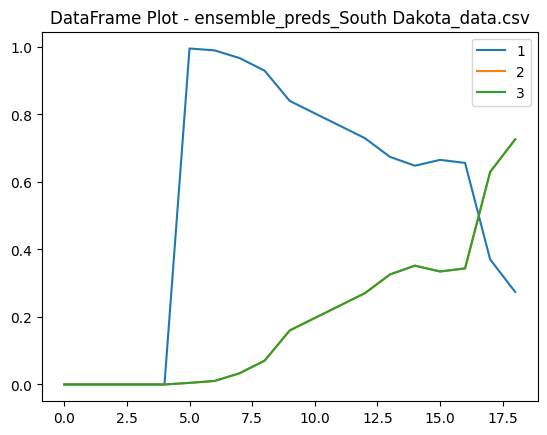

Puerto Rico


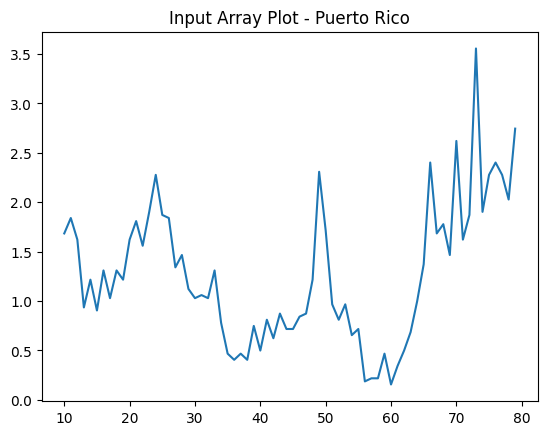

<Figure size 640x480 with 0 Axes>

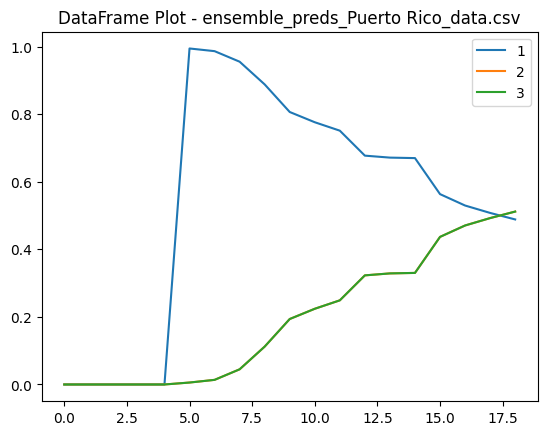

District of Columbia


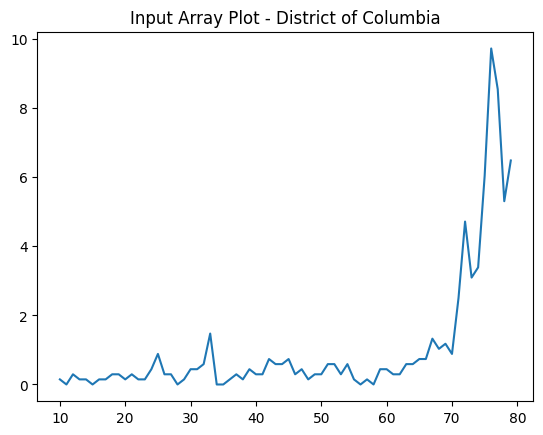

<Figure size 640x480 with 0 Axes>

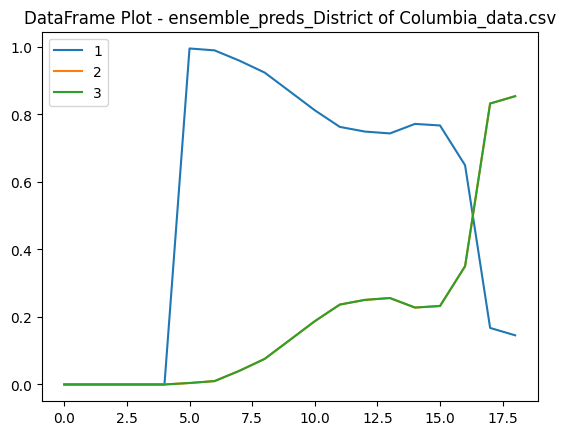

Illinois


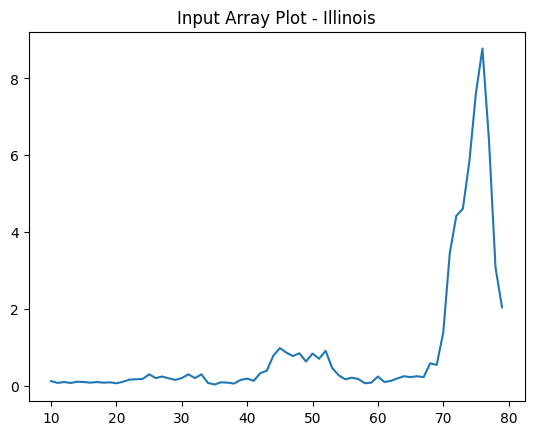

<Figure size 640x480 with 0 Axes>

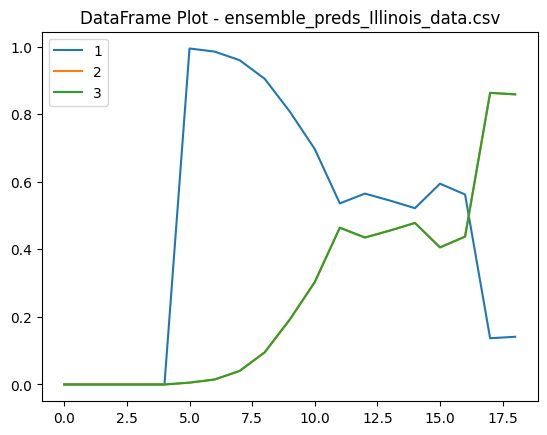

In [78]:
output_base_path = '/content/predictions_image_plots'

if os.path.exists(output_base_path):
    for root, dirs, files in os.walk(output_base_path, topdown=False):
        for name in files:
            os.remove(os.path.join(root, name))  # Delete files
        for name in dirs:
            os.rmdir(os.path.join(root, name))  # Delete directories


for filename in os.listdir(ensemble_predictions_path):
    if filename.endswith('.csv'):
        filepath = os.path.join(ensemble_predictions_path, filename)
        df = pd.read_csv(filepath)  # Read the CSV file into a pandas DataFrame


        df.columns = range(1, len(df.columns) + 1)
        # Create an artificial time axis using the number of rows in the DataFrame
        time = np.arange(len(df))

        name = filename.split('_')[-2].split('.')[0]

        state_folder = os.path.join(output_base_path, name)
        os.makedirs(state_folder, exist_ok=True)

        # plt.figure()
        print(name)
        plt.figure()  # Create a new figure for the input array plot
        # input_array[name] = input_array[name].dropna()
        ax = input_array[name].plot()#.iloc[from_time:to_time].reset_index(drop=True).plot()
        # Get the figure
        fig = ax.get_figure()

        # Save the figure as a PNG image
        fig.savefig(os.path.join(state_folder, f"{name}_input_array_plot.png"))
        plt.title(f"Input Array Plot - {name}")

        plt.figure()  # Create a new figure for the DataFrame plot
        ax2 = df.plot()
        # Get the figure
        fig2 = ax2.get_figure()

        # Save the figure as a PNG image
        fig2.savefig(os.path.join(state_folder, f"{name}_dataframe_plot.png"))
        plt.title(f"DataFrame Plot - {filename}")

        plt.show()  # Display both plots
        # # Plot all three columns against time
        # plt.plot(time, df.iloc[:, 0], label='Column 1')
        # plt.plot(time, df.iloc[:, 1], label='Column 2')
        # plt.plot(time, df.iloc[:, 2], label='Column 3')

        # plt.title(filename)  # Set the title of the plot to the filename
        # plt.xlabel('Artificial Time')  # Set the x-axis label
        # plt.ylabel('Values')  # Set the y-axis label
        # plt.legend()  # Show legend to distinguish the columns
        # plt.show()  # Display the plot